In [1]:
import torch
import importlib
from torchvision import transforms
from IPython.display import display
import numpy as np


import dataset.dataset
import dataset.pair_generator
import util
import simclr
importlib.reload(dataset.dataset)
importlib.reload(dataset.pair_generator)
importlib.reload(util)
importlib.reload(simclr)

from dataset.dataset import UnlabeledDataset, LabeledDataset
from dataset.pair_generator import PairGenerator
from util import to_tensor_image, KNN
from simclr import SimCLR

/home/lspss95207/anaconda3/envs/hw2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Seed

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Load training dataset

In [3]:
from torchvision import datasets
n_views = 2
batch_size = 10
num_workers = 0                                                                

train_dataset = UnlabeledDataset(root="../data/unlabeled", transform=PairGenerator(n_views=n_views))
# train_dataset = datasets.STL10("../data/stl10", split='unlabeled',
#                                                           transform=PairGenerator(n_views),
#                                                           download=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True,
    num_workers = num_workers, pin_memory = True, drop_last = True)


### Sample some training dataset image

Dataset size = 7294
Image 0
Transform 0


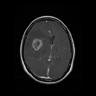

Transform 1


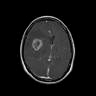

Image 1
Transform 0


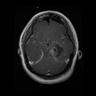

Transform 1


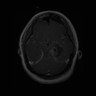

Image 2
Transform 0


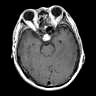

Transform 1


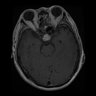

In [4]:
print("Dataset size =", len(train_dataset))

for i in range(3):
    print(f"Image {i}")
    for j, img in enumerate(train_dataset[i][0]):
        print(f"Transform {j}")
        display(to_tensor_image(img))

### Training

In [5]:
epochs = 1
lr = 0.0003
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

simclr = SimCLR(out_dim=512, device=device)

simclr.train(train_loader=train_loader, batch_size=batch_size, n_views=n_views, lr=lr, weight_decay=weight_decay, epochs=epochs)


100%|██████████| 729/729 [00:32<00:00, 22.54it/s]


### Load testing dataset

In [6]:
test_dataset = LabeledDataset(root="../data/test")

### Sample some testing dataset image

image 0   label = 0


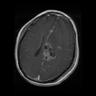

image 1   label = 0


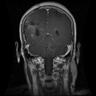

image 2   label = 0


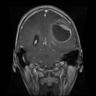

In [7]:
for i in range(3):
    img, label = test_dataset[i]
    print(f"image {i}   label = {label}")
    display(img)

### Testing Accuracy

In [8]:
test_embedding = simclr.get_embedding(test_dataset)

print("test_embedding.dtype:", test_embedding.dtype)
print("test_embedding.shape:", test_embedding.shape)

test_labels_tensor = torch.tensor([label for _, label in test_dataset])
test_embedding_tensor = torch.tensor(test_embedding)
acc = KNN(test_embedding_tensor, test_labels_tensor, batch_size=16)
print("Accuracy: %.5f" % acc)


test_embedding.dtype: float32
test_embedding.shape: (500, 512)
Accuracy: 0.77400


### Create result embedding

In [9]:
result_dataset = UnlabeledDataset(root="../data/unlabeled")
result_embeddeing = simclr.get_embedding(result_dataset)

print("result_embeddeing.dtype", result_embeddeing.dtype)
print("result_embeddeing.shape", result_embeddeing.shape)

np.save("../0710764.npy", result_embeddeing)


result_embeddeing.dtype float32
result_embeddeing.shape (7294, 512)
